__собираем статистики по объявлениям__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
# import re
# import numpy as np
# from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd
# import contextily as ctx
# from shapely.geometry import Polygon

/opt/venv/python3.10/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)
# tqdm.pandas()

In [3]:
# !ls -1 data

## считываем данные

In [4]:
data_file = 'data/data_land.pkl'

In [5]:
cols = ['title','adr','latitude','longitude','priceM','ts']
df = pd.read_pickle(data_file)
df['dt'] = pd.to_datetime( df['ts'].dt.date )
print(len(df))
df.sample(3)[cols]

8815


,title,adr,latitude,longitude,priceM,ts
7539,Участок 8 сот. (ИЖС),"Севастополь,ул. Челнокова, 15/28",44.59,33.43,60.00,2022-09-22 09:57:15.623
7650,"Участок 12,5 сот. (ИЖС)","Севастополь,пр-т Героев Сталинграда",44.59,33.45,36.00,2022-09-22 09:57:15.623
6155,Участок 15 сот. (ИЖС),"Севастополь,Балаклава, Краснознамённая ул., 9",44.51,33.60,14.00,2022-09-19 12:39:53.571


In [6]:
# df.loc[ df['adr_orig']=='Севастополь, Чёрное море', ['latitude','longitude'] ] = None

In [7]:
df.loc[ df['adr_orig'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8815 entries, 0 to 8814
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   title               8815 non-null   object        
 1   price               8815 non-null   int64         
 2   obj_name            8815 non-null   object        
 3   adr_orig            8815 non-null   object        
 4   description         8815 non-null   object        
 5   avito_page          8815 non-null   int64         
 6   ts                  8815 non-null   datetime64[ns]
 7   place               8815 non-null   object        
 8   area                8815 non-null   float64       
 9   is_IJS              8815 non-null   bool          
 10  priceM              8815 non-null   float64       
 11  priceMU             8815 non-null   float64       
 12  area_size_category  8815 non-null   category      
 13  url                 8815 non-null   object      

In [9]:
df.sample(3)[cols]

,title,adr,latitude,longitude,priceM,ts
4197,"Участок 6,2 сот. (ИЖС)","Севастополь,ул. Симонок",44.63,33.53,7.50,2022-09-15 10:31:26.039
5805,"Участок 11,2 сот. (ИЖС)","Севастополь,район Северная Сторона",44.63,33.55,2.80,2022-09-19 12:39:53.571
7310,Участок 6 сот. (ИЖС),"Севастополь,ТСН Родник",44.55,33.56,4.80,2022-09-22 09:57:15.623


In [10]:
# берём объявления с геометкой
print(len(df))
df = df[ (~df['latitude'].isnull()) ].reset_index(drop=True)
print(len(df))

8815
8806


### ограничиваем тип объекта 

In [11]:
# print(len(df))
# # выкидываем "ущербные" варианты 
# df = df.query('is_IJS')
# print(len(df))

In [12]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
gdf.sample(3)[['title','adr','latitude','longitude','priceM']]

,title,adr,latitude,longitude,priceM
17,Участок 5 сот. (ИЖС),"Севастополь,Нахимовский район",44.70,33.65,1.23
7961,"Участок 8,2 сот. (ИЖС)","Севастополь,Гагаринский район , наб. Андрея Первозванного, 7",44.60,33.44,23.00
1138,"Участок 5,7 сот. (ИЖС)","Севастополь,Монастырское ш., 116Г/1А",44.51229,33.503612,1.75


In [13]:
del df

In [14]:
gdf[['title','priceM','area_size_category','geometry']].sample(100).explore('area_size_category', legend=True) 

## общая статистика изменение цены

In [15]:
ts = '2022-08-01' # ограничиваем дату

In [16]:
stat = (
    gdf.query('priceM>1.')
    .groupby(['area_size_category','dt'])
    ['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
)
stat

count  mean   std  min  10%   25%   50%   75%  \
area_size_category dt                                                          
<1                 2022-09-08   2.00  8.07  9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-12   2.00  8.07  9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-13   2.00  8.07  9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-15   2.00  8.07  9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-16   2.00  8.07  9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-19   2.00  8.07  9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-22   2.00  8.07  9.79 1.15 2.53  4.61  8.07 11.54   
                   2022-09-26   2.00  8.07  9.79 1.15 2.53  4.61  8.07 11.54   
1-2                2022-09-08   3.00  1.80  0.10 1.70 1.72  1.75  1.80  1.85   
                   2022-09-12   3.00  1.80  0.10 1.70 1.72  1.75  1.80  1.85   
                   2022-09-13   3.00  1.80  0.10 1.70 1.72  1.75  1.80  1.85   
                   2022-09-15   3.00  1.77  0.06 1.70 1.72  1.75  1.80  1.80   
                   2022-09-16   3.00  1.77  0.06 1.70 1.72  1.75  1.80  1.80   
                   2022-09-19   2.00  1.80  0.00 1.80 1.80  1.80  1.80  1.80   
                   2022-09-22   2.00  1.80  0.00 1.80 1.80  1.80  1.80  1.80   
                   2022-09-26   3.00  1.60  0.35 1.20 1.32  1.50  1.80  1.80   
2-4                2022-09-08 143.00  3.46  1.87 1.15 1.59  2.05  2.85  4.38   
                   2022-09-12 144.00  3.61  2.34 1.15 1.61  2.17  2.88  4.50   
                   2022-09-13 149.00  3.57  2.29 1.15 1.60  2.10  2.99  4.50   
                   2022-09-15 152.00  3.59  2.28 1.15 1.70  2.19  2.92  4.50   
                   2022-09-16 148.00  3.60  2.26 1.15 1.70  2.20  3.00  4.50   
                   2022-09-19 147.00  3.51  2.26 1.15 1.65  2.10  2.75  4.50   
                   2022-09-22 152.00  3.59  2.28 1.15 1.65  2.20  3.00  4.50   
                   2022-09-26 148.00  3.62  2.28 1.15 1.69  2.20  3.05  4.50   
4-8                2022-09-08 518.00  4.52  3.41 1.10 1.90  2.50  3.50  5.20   
                   2022-09-12 550.00  4.55  4.02 1.10 1.90  2.50  3.50  5.20   
                   2022-09-13 553.00  4.48  3.99 1.10 1.86  2.50  3.40  5.10   
                   2022-09-15 550.00  4.43  3.86 1.10 1.85  2.45  3.45  5.07   
                   2022-09-16 541.00  4.49  4.17 1.10 1.85  2.45  3.35  5.20   
                   2022-09-19 544.00  4.41  3.86 1.10 1.85  2.40  3.40  5.20   
                   2022-09-22 546.00  4.48  3.92 1.10 1.85  2.45  3.37  5.20   
                   2022-09-26 530.00  4.38  3.82 1.10 1.90  2.40  3.30  5.20   
8-20               2022-09-08 348.00  6.40  6.57 1.10 2.00  3.00  4.60  7.41   
                   2022-09-12 343.00  6.28  6.19 1.10 2.00  3.00  4.60  7.00   
                   2022-09-13 344.00  6.37  6.24 1.10 2.00  3.00  4.60  7.03   
                   2022-09-15 349.00  6.40  6.28 1.10 2.00  3.00  4.50  7.00   
                   2022-09-16 344.00  6.39  6.25 1.10 2.00  3.00  4.50  7.00   
                   2022-09-19 345.00  6.42  6.47 1.10 2.00  2.90  4.50  7.00   
                   2022-09-22 343.00  6.36  6.43 1.10 2.00  2.85  4.50  7.00   
                   2022-09-26 338.00  6.35  6.41 1.10 2.00  2.96  4.50  6.96   
20+                2022-09-08  34.00 33.26 30.40 1.10 5.40 14.00 23.50 37.75   
                   2022-09-12  35.00 31.53 30.52 1.10 3.54 11.00 21.00 37.50   
                   2022-09-13  35.00 33.32 31.20 1.10 4.80 12.75 21.00 44.00   
                   2022-09-15  40.00 31.43 33.43 1.10 2.99  8.30 17.25 37.25   
                   2022-09-16  37.00 33.52 33.91 2.10 5.70 10.00 19.00 38.00   
                   2022-09-19  41.00 32.67 33.05 2.10 3.00  8.30 19.00 40.00   
                   2022-09-22  40.00 31.54 32.82 1.55 2.99  8.10 18.50 38.50   
                   2022-09-26  40.00 30.46 30.36 1.55 2.99  8.82 18.50 38.50   

                              

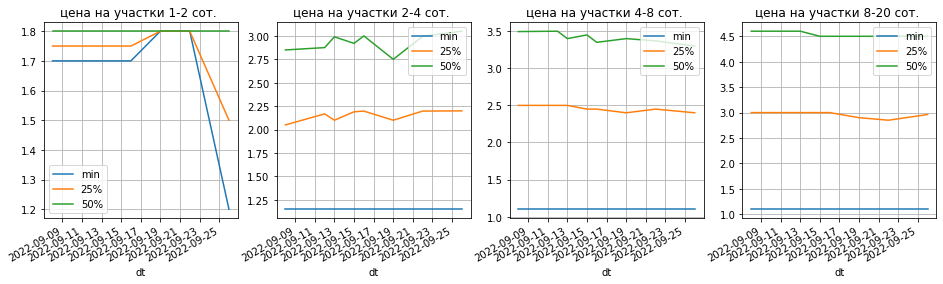

In [17]:
import matplotlib.pyplot as plt

# sizes = [ '<1', '1-2', '2-4', '4-8', '8-20', '20+', ]
sizes = [ '1-2', '2-4', '4-8', '8-20', ]

fig, ax = plt.subplots(1,len(sizes),figsize=(16,4))
for i,s in enumerate(sizes): 
    stat.loc[s,['min','25%','50%']].plot(grid=True, title=f'цена на участки {s} сот. ',ax=ax[i])

### район поиска

In [18]:
from shapely.geometry import MultiPoint

frame_all = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_all.explore()

### гексагональная сетка

In [19]:
import h3
from shapely.geometry import Polygon
    
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [20]:
grid = cover_grid_hexagonal( frame_all.geometry.values[0] )
print(len(grid))
grid.sample(2)

36


,hex_id,geometry
16,862d2d48fffffff,"POLYGON ((33.69636 44.77011, 33.67486 44.74076, 33.70175 44.71197, 33.75012 44.71254, 33.77163 44.74188, 33.74476 44.77067, 33.69636 44.77011))"
6,862d28947ffffff,"POLYGON ((33.49229 44.62190, 33.47089 44.59244, 33.49782 44.56366, 33.54614 44.56432, 33.56756 44.59377, 33.54065 44.62256, 33.49229 44.62190))"


### медиана актуальной цены

In [21]:
# новые предложения
gdf_ = gdf[ (gdf['dt']>ts)  ] # & (gdf['priceM']<15.)

grid_values = ( 
    grid
    .sjoin(gdf_, how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

## ограничиваем по район поиска

In [22]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
    { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
    for nm,f in frames_index.values
],crs='epsg:4326',)

frames

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка","POLYGON ((33.53426 44.59526, 33.54470 44.58945, 33.54804 44.58596, 33.55346 44.58519, 33.55707 44.57912, 33.56296 44.57711, 33.54048 44.56941, 33.53004 44.59308, 33.53426 44.59526))"
6,"Севастополь, Малахов курган","POLYGON ((33.54313 44.60612, 33.55331 44.61155, 33.55676 44.60803, 33.55772 44.60255, 33.55385 44.60019, 33.54414 44.60247, 33.54313 44.60612))"


In [23]:
frames.explore('area_name')

In [24]:
area_name=[
#'Севастополь, парк 60-летия СССР',
#'Севастополь, Хрусталёва/Хрюкина',
#'Севастополь, район Острякова',
'Севастополь, кр.горка',
]

# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
print(len(gdf))
gdf_ = gdf.sjoin( frame_, how='inner', predicate='within') 
print(len(gdf_))

8806
308


In [25]:
# новые (актуальные) предложения
cols=['title','priceM','adr','area_size_category','geometry']
gdf_[gdf_['ts']>ts][cols].explore( 'area_size_category',legend=True)

### изменение цены

In [26]:
stat = (
    gdf_.query('priceM>1.')
    .groupby(['area_size_category','dt'])
    ['priceM'].describe(percentiles=[.1,.25,.5,.75,.9])
)
stat

count   mean  std    min    10%    25%    50%  \
area_size_category dt                                                          
2-4                2022-09-08   4.00   2.91 0.53   2.60   2.62   2.64   2.67   
                   2022-09-12   4.00   2.91 0.53   2.60   2.62   2.64   2.67   
                   2022-09-13   4.00   2.91 0.53   2.60   2.62   2.64   2.67   
                   2022-09-15   4.00   2.91 0.53   2.60   2.62   2.64   2.67   
                   2022-09-16   5.00   2.85 0.48   2.60   2.60   2.60   2.65   
                   2022-09-19   5.00   2.85 0.48   2.60   2.60   2.60   2.65   
                   2022-09-22   5.00   2.85 0.48   2.60   2.60   2.60   2.65   
                   2022-09-26   4.00   2.91 0.53   2.60   2.61   2.64   2.67   
4-8                2022-09-08  22.00   3.75 2.17   1.60   2.00   2.23   2.75   
                   2022-09-12  25.00   3.48 1.89   1.45   1.80   2.20   2.80   
                   2022-09-13  24.00   3.27 1.61   1.45   1.80   2.20   2.75   
                   2022-09-15  25.00   3.21 1.61   1.45   1.80   2.20   2.70   
                   2022-09-16  24.00   3.30 1.67   1.45   1.80   2.15   2.75   
                   2022-09-19  24.00   3.35 1.67   1.45   1.80   2.15   2.90   
                   2022-09-22  27.00   3.31 1.65   1.45   1.70   2.10   2.80   
                   2022-09-26  22.00   3.21 1.54   1.55   1.80   2.20   2.75   
8-20               2022-09-08   9.00   6.02 5.10   1.65   2.33   3.10   4.25   
                   2022-09-12   8.00   6.21 4.71   1.65   2.67   3.18   4.53   
                   2022-09-13   9.00   6.43 4.45   1.65   2.81   3.20   4.80   
                   2022-09-15  10.00   5.44 4.46   1.65   2.10   2.72   3.73   
                   2022-09-16   9.00   5.76 4.61   1.65   2.05   3.10   4.25   
                   2022-09-19   9.00   5.76 4.61   1.65   2.05   3.10   4.25   
                   2022-09-22   9.00   6.26 5.54   1.65   2.05   3.00   4.25   
                   2022-09-26  10.00   5.77 4.76   1.65   2.10   3.02   4.12   
20+                2022-09-08   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-12   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-13   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-15   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-16   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-19   1.00 120.00  NaN 120.00 120.00 120.00 120.00   
                   2022-09-22   1.00 120.00  NaN 120.00 120.00 120.00 120.00   

                                 75%    90%    max  
area_size_category dt                               
2-4                2022-09-08   2.95   3.40   3.70  
                   2022-09-12   2.95   3.40   3.70  
                   2022-09-13   2.95   3.40   3.70  
                   2022-09-15   2.95   3.40   3.70  
                   2022-09-16   2.70   3.30   3.70  
                   2022-09-19   2.70   3.30   3.70  
                   2022-09-22   2.70   3.30   3.70  
                   2022-09-26   2.95   3.40   3.70  
4-8                2022-09-08   4.78   7.86   8.50  
                   2022-09-12   4.50   5.88   8.50  
                   2022-09-13   3.97   4.80   8.00  
                   2022-09-15   3.80   4.80   8.00  
                   2022-09-16   4.50   4.94   8.00  
                   2022-09-19   4.50   4.94   8.00  
                   2022-09-22   4.50   5.08   8.00  
                   2022-09-26   4.22   4.98   6.70  
8-20               2022-09-08   5.80  12.92  17.00  
                   2022-09-12   7.33  12.83  15.00  
                   2022-09-13   8.20  12.52  15.00  
                   2022-09-15   5.55  12.21  15.00  
                   2022-09-16   5.80  12.52  15.00  
                   2022-09-19   5.80  12.52  15.00  
                   2022-09-22   5.80  15.30  16.50  
                   2022-09-26   5.55  14.10  15.00  
20+         

In [27]:
gdf_['area_size_category'].unique()

['8-20', '4-8', '2-4', '20+']
Categories (6, object): ['<1' < '1-2' < '2-4' < '4-8' < '8-20' < '20+']

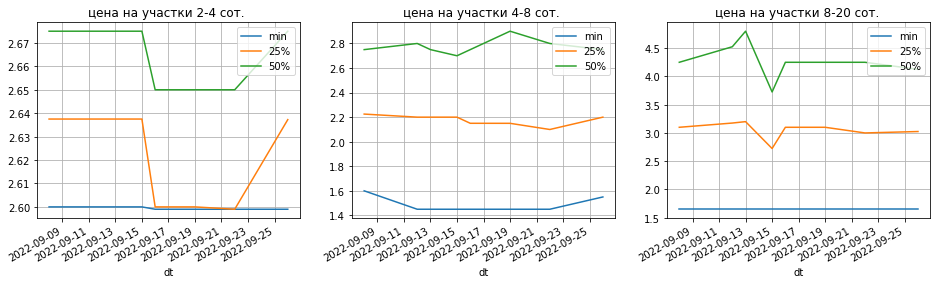

In [28]:
import matplotlib.pyplot as plt

# sizes = gdf_['area_size_category'].unique()
# sizes = [ '<1', '1-2', '2-4', '4-8', '8-20', '20+', ]
sizes = [ '2-4', '4-8', '8-20', ]

fig, ax = plt.subplots(1,len(sizes),figsize=(16,4))
for i,s in enumerate(sizes): 
    stat.loc[s,['min','25%','50%']].plot(grid=True, title=f'цена на участки {s} сот. ',ax=ax[i])

### гексагональная сетка

In [29]:
grid = cover_grid_hexagonal( frame_.geometry.values[0], cell_size=9 )
print(len(grid))
grid.sample(2)

32


,hex_id,geometry
21,892d289422bffff,"POLYGON ((33.54119 44.57497, 33.54086 44.57318, 33.54295 44.57202, 33.54536 44.57265, 33.54568 44.57444, 33.54360 44.57560, 33.54119 44.57497))"
12,892d28943c7ffff,"POLYGON ((33.54138 44.58866, 33.54105 44.58687, 33.54314 44.58571, 33.54555 44.58633, 33.54587 44.58812, 33.54379 44.58929, 33.54138 44.58866))"


### медиана актуальной цены

In [30]:
grid_values = (
    grid
    .sjoin( gdf[ gdf['dt']>ts ], how='inner',)
    .groupby(['hex_id'])
    ['priceM']
    .median()
    .reset_index()
)

grid.merge(grid_values,on='hex_id').explore('priceM',cmap='rainbow') #'area_name', legend=True)

In [31]:
# gdf[['latitude','longitude']].max()

# min
# latitude    43.23
# longitude   33.40

# max
# latitude    44.90
# longitude   34.19

In [32]:
# from shapely.geometry import Point

# gpd.GeoDataFrame(
#     {'pos':['min','max']},
#     geometry=gpd.points_from_xy( [33.40,34.19], [43.23,44.90]),
#     crs='epsg:4326',
# ).explore()